In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from fpdf import FPDF
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

# Load both datasets
df = pd.read_csv('telco_churn_cleaned.csv')
df_scored = pd.read_csv('telco_churn_scored.csv')

print("Data loaded successfully!")
print(f"Cleaned data: {len(df)} rows")
print(f"Scored data: {len(df_scored)} rows")

Data loaded successfully!
Cleaned data: 7043 rows
Scored data: 7043 rows


In [2]:
# Core churn metrics
total_customers = len(df)
churned = df[df['Churn'] == 'Yes']
retained = df[df['Churn'] == 'No']
churn_rate = len(churned) / total_customers * 100
monthly_revenue_lost = churned['MonthlyCharges'].sum()
annual_revenue_lost = monthly_revenue_lost * 12

# Contract breakdown
contract_churn = df.groupby('Contract').apply(
    lambda x: (x['Churn'] == 'Yes').mean() * 100).round(1)

# Tenure insights
avg_tenure_churned = churned['tenure'].mean()
avg_tenure_retained = retained['tenure'].mean()

# Monthly charges
avg_charge_churned = churned['MonthlyCharges'].mean()
avg_charge_retained = retained['MonthlyCharges'].mean()

# Risk segments from scored data
high_risk = df_scored[df_scored['ML_Risk_Level'] == 'HIGH RISK']
medium_risk = df_scored[df_scored['ML_Risk_Level'] == 'MEDIUM RISK']
low_risk = df_scored[df_scored['ML_Risk_Level'] == 'LOW RISK']

high_risk_revenue = high_risk['MonthlyCharges'].sum() * 12
potential_save_30pct = high_risk_revenue * 0.30

print("=" * 55)
print("REPORT KPI SUMMARY")
print("=" * 55)
print(f"Total Customers          : {total_customers:,}")
print(f"Churned Customers        : {len(churned):,}")
print(f"Overall Churn Rate       : {churn_rate:.1f}%")
print(f"Monthly Revenue Lost     : ${monthly_revenue_lost:,.0f}")
print(f"Annual Revenue Lost      : ${annual_revenue_lost:,.0f}")
print(f"Avg Tenure Churned       : {avg_tenure_churned:.1f} months")
print(f"Avg Tenure Retained      : {avg_tenure_retained:.1f} months")
print(f"High Risk Customers      : {len(high_risk):,}")
print(f"Annual Revenue at Risk   : ${high_risk_revenue:,.0f}")
print(f"Potential Annual Savings : ${potential_save_30pct:,.0f}")
print("=" * 55)

REPORT KPI SUMMARY
Total Customers          : 7,043
Churned Customers        : 1,869
Overall Churn Rate       : 26.5%
Monthly Revenue Lost     : $139,131
Annual Revenue Lost      : $1,669,570
Avg Tenure Churned       : 18.0 months
Avg Tenure Retained      : 37.6 months
High Risk Customers      : 434
Annual Revenue at Risk   : $450,947
Potential Annual Savings : $135,284


In [3]:
os.makedirs('report_charts', exist_ok=True)
print("Report charts folder created!")

Report charts folder created!


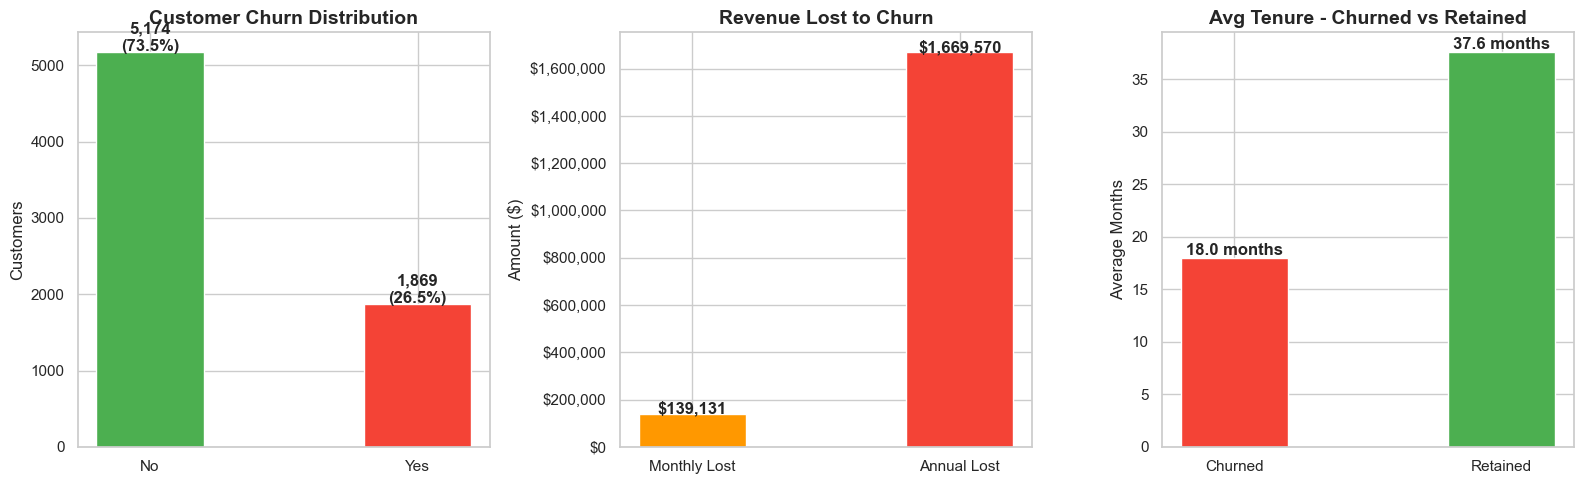

Report Chart 1 saved!


In [4]:
# Report Chart 1 - Churn Overview
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Churn distribution
churn_counts = df['Churn'].value_counts()
axes[0].bar(churn_counts.index, churn_counts.values,
            color=['#4CAF50', '#F44336'], width=0.4)
axes[0].set_title('Customer Churn Distribution')
axes[0].set_ylabel('Customers')
for bar, val in zip(axes[0].patches, churn_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 20,
                 f'{val:,}\n({val/total_customers*100:.1f}%)',
                 ha='center', fontweight='bold')

# Revenue impact
labels = ['Monthly Lost', 'Annual Lost']
values = [monthly_revenue_lost, annual_revenue_lost]
colors = ['#FF9800', '#F44336']
axes[1].bar(labels, values, color=colors, width=0.4)
axes[1].set_title('Revenue Lost to Churn')
axes[1].set_ylabel('Amount ($)')
axes[1].yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for bar, val in zip(axes[1].patches, values):
    axes[1].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 1000,
                 f'${val:,.0f}', ha='center', fontweight='bold')

# Tenure comparison
tenure_data = [avg_tenure_churned, avg_tenure_retained]
axes[2].bar(['Churned', 'Retained'], tenure_data,
            color=['#F44336', '#4CAF50'], width=0.4)
axes[2].set_title('Avg Tenure - Churned vs Retained')
axes[2].set_ylabel('Average Months')
for bar, val in zip(axes[2].patches, tenure_data):
    axes[2].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.3,
                 f'{val:.1f} months', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('report_charts/rc1_churn_overview.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("Report Chart 1 saved!")

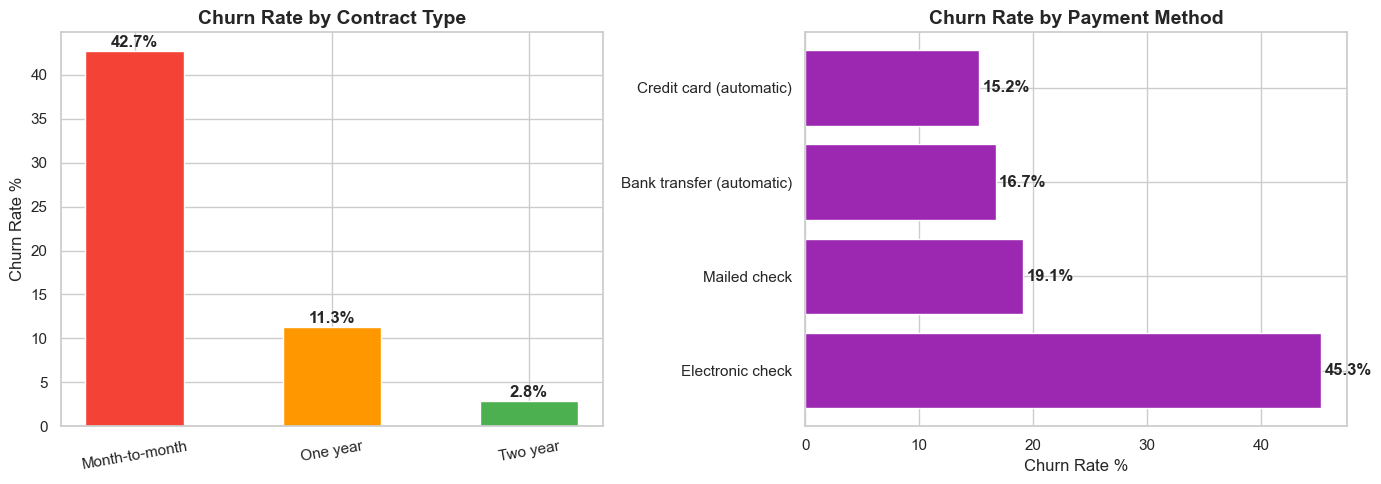

Report Chart 2 saved!


In [5]:
# Report Chart 2 - Contract and Payment Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contract churn rate
contract_churn_rate = df.groupby('Contract')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100)
colors_c = ['#F44336', '#FF9800', '#4CAF50']
bars = axes[0].bar(contract_churn_rate.index,
                   contract_churn_rate.values,
                   color=colors_c, width=0.5)
axes[0].set_title('Churn Rate by Contract Type')
axes[0].set_ylabel('Churn Rate %')
axes[0].tick_params(axis='x', rotation=10)
for bar, val in zip(bars, contract_churn_rate.values):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.5,
                 f'{val:.1f}%', ha='center', fontweight='bold')

# Payment method churn rate
payment_churn = df.groupby('PaymentMethod')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100).sort_values(ascending=False)
axes[1].barh(payment_churn.index, payment_churn.values,
             color='#9C27B0')
axes[1].set_title('Churn Rate by Payment Method')
axes[1].set_xlabel('Churn Rate %')
for bar, val in zip(axes[1].patches, payment_churn.values):
    axes[1].text(val + 0.3, bar.get_y() + bar.get_height()/2,
                 f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('report_charts/rc2_contract_payment.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("Report Chart 2 saved!")

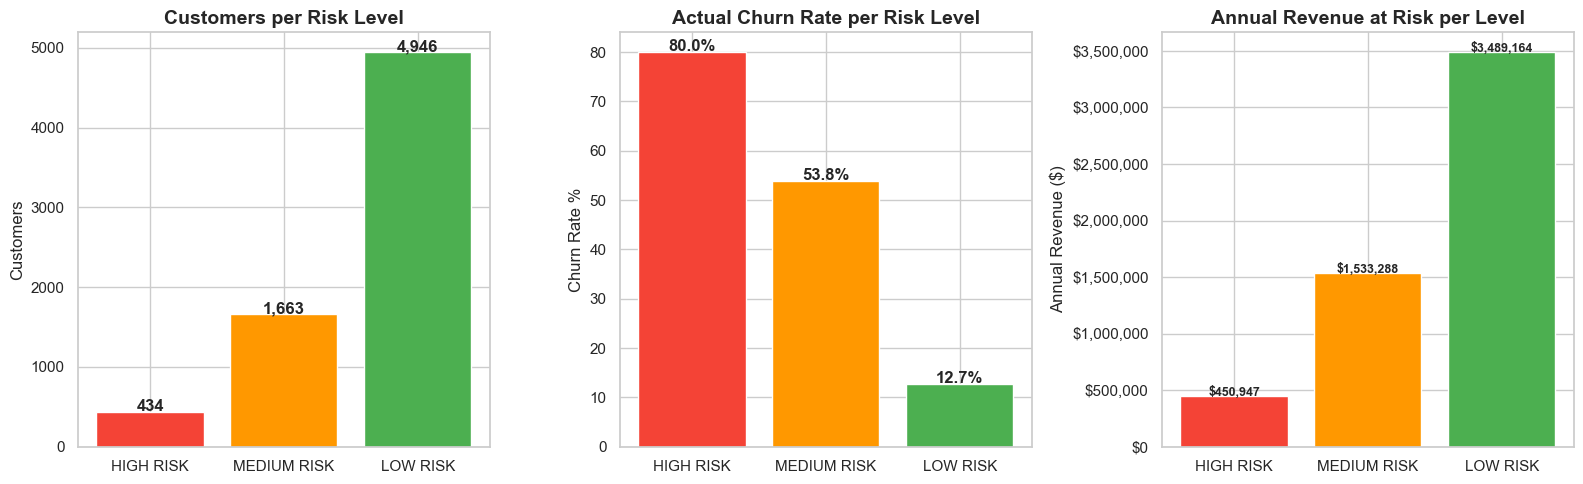

Report Chart 3 saved!


In [6]:
# Report Chart 3 - Risk Segmentation
risk_summary = df_scored.groupby('ML_Risk_Level').agg(
    Customers=('customerID', 'count'),
    Monthly_Revenue=('MonthlyCharges', 'sum'),
    Churn_Rate=('Churn_Binary', 'mean')
).reset_index()
risk_summary['Annual_Revenue'] = risk_summary['Monthly_Revenue'] * 12
risk_summary['Churn_Rate'] = (risk_summary['Churn_Rate'] * 100).round(1)

order = ['HIGH RISK', 'MEDIUM RISK', 'LOW RISK']
risk_summary['ML_Risk_Level'] = pd.Categorical(
    risk_summary['ML_Risk_Level'], categories=order, ordered=True)
risk_summary = risk_summary.sort_values('ML_Risk_Level')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors_r = ['#F44336', '#FF9800', '#4CAF50']

axes[0].bar(risk_summary['ML_Risk_Level'],
            risk_summary['Customers'], color=colors_r)
axes[0].set_title('Customers per Risk Level')
axes[0].set_ylabel('Customers')
for bar, val in zip(axes[0].patches, risk_summary['Customers']):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 10, f'{val:,}',
                 ha='center', fontweight='bold')

axes[1].bar(risk_summary['ML_Risk_Level'],
            risk_summary['Churn_Rate'], color=colors_r)
axes[1].set_title('Actual Churn Rate per Risk Level')
axes[1].set_ylabel('Churn Rate %')
for bar, val in zip(axes[1].patches, risk_summary['Churn_Rate']):
    axes[1].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.3, f'{val}%',
                 ha='center', fontweight='bold')

axes[2].bar(risk_summary['ML_Risk_Level'],
            risk_summary['Annual_Revenue'], color=colors_r)
axes[2].set_title('Annual Revenue at Risk per Level')
axes[2].set_ylabel('Annual Revenue ($)')
axes[2].yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
for bar, val in zip(axes[2].patches, risk_summary['Annual_Revenue']):
    axes[2].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 1000, f'${val:,.0f}',
                 ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('report_charts/rc3_risk_segments.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("Report Chart 3 saved!")

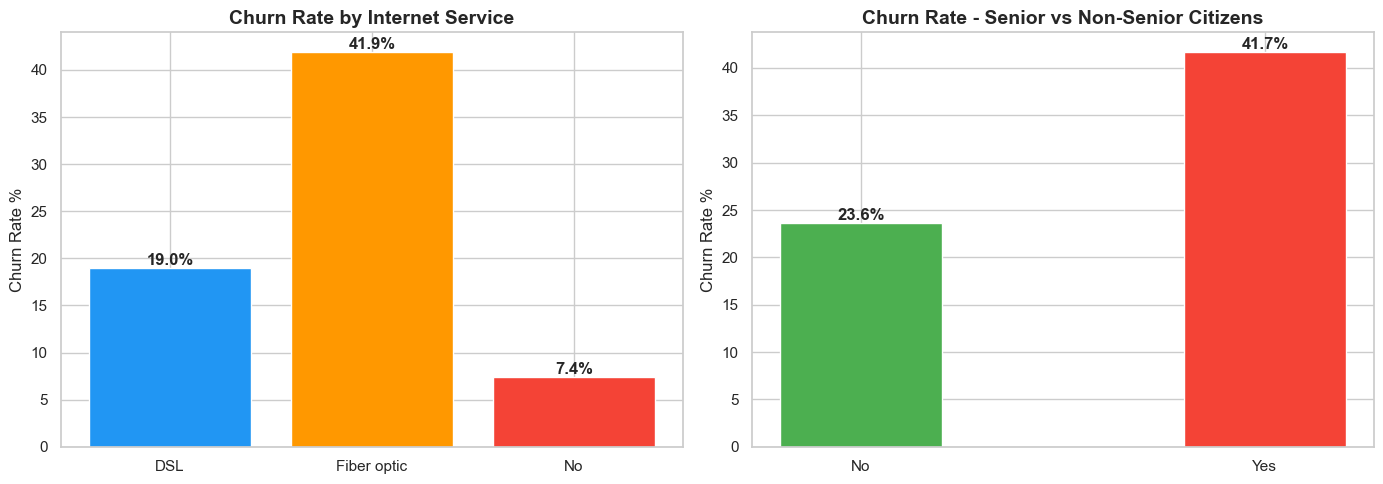

Report Chart 4 saved!


In [7]:
# Report Chart 4 - Key Churn Drivers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Internet service churn
internet_churn = df.groupby('InternetService')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100)
axes[0].bar(internet_churn.index, internet_churn.values,
            color=['#2196F3', '#FF9800', '#F44336'])
axes[0].set_title('Churn Rate by Internet Service')
axes[0].set_ylabel('Churn Rate %')
for bar, val in zip(axes[0].patches, internet_churn.values):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.3,
                 f'{val:.1f}%', ha='center', fontweight='bold')

# Senior citizen churn
senior_churn = df.groupby('SeniorCitizen')['Churn'].apply(
    lambda x: (x == 'Yes').mean() * 100)
axes[1].bar(senior_churn.index, senior_churn.values,
            color=['#4CAF50', '#F44336'], width=0.4)
axes[1].set_title('Churn Rate - Senior vs Non-Senior Citizens')
axes[1].set_ylabel('Churn Rate %')
for bar, val in zip(axes[1].patches, senior_churn.values):
    axes[1].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.3,
                 f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('report_charts/rc4_churn_drivers.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("Report Chart 4 saved!")

In [8]:
class ChurnReportPDF(FPDF):

    def header(self):
        self.set_fill_color(63, 81, 181)
        self.rect(0, 0, 210, 18, 'F')
        self.set_font('Helvetica', 'B', 13)
        self.set_text_color(255, 255, 255)
        self.set_y(4)
        self.cell(0, 10,
                  '  Customer Churn Analysis Report - Telecom Dataset',
                  align='L')
        self.set_text_color(0, 0, 0)
        self.ln(14)

    def footer(self):
        self.set_y(-15)
        self.set_font('Helvetica', 'I', 8)
        self.set_text_color(150, 150, 150)
        report_date = datetime.now().strftime("%B %d, %Y")
        self.cell(0, 10,
                  f'Generated: {report_date}  |  Confidential  |  Page {self.page_no()}',
                  align='C')

    def cover_page(self):
        self.add_page()
        self.set_fill_color(63, 81, 181)
        self.rect(0, 40, 210, 65, 'F')
        self.set_y(52)
        self.set_font('Helvetica', 'B', 26)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, 'CUSTOMER CHURN', align='C')
        self.ln(13)
        self.cell(0, 12, 'ANALYSIS REPORT', align='C')
        self.ln(13)
        self.set_font('Helvetica', '', 14)
        self.cell(0, 10, 'Telecom Dataset - Predictive Analytics', align='C')
        self.set_y(120)
        self.set_text_color(0, 0, 0)
        self.set_font('Helvetica', 'B', 12)
        report_date = datetime.now().strftime("%B %d, %Y")
        self.cell(0, 8, f'Report Date: {report_date}', align='C')
        self.ln(8)
        self.set_font('Helvetica', '', 11)
        self.cell(0, 8, 'Prepared by: Your Name | Data Analyst', align='C')
        self.ln(8)
        self.cell(0, 8, 'Dataset: IBM Telco Customer Churn Dataset', align='C')
        self.set_y(150)
        self.set_font('Helvetica', 'B', 13)
        self.set_fill_color(240, 240, 240)
        self.cell(0, 10, '  Contents', align='L', fill=True)
        self.ln(12)
        contents = [
            '1.  Executive Summary - Situation and Key Findings',
            '2.  Churn Overview - Scale and Revenue Impact',
            '3.  Churn Driver Analysis - Why Customers Leave',
            '4.  Customer Risk Segmentation - Who to Target',
            '5.  Machine Learning Model - Predictive Accuracy',
            '6.  Action Plan - Prioritized Recommendations',
        ]
        self.set_font('Helvetica', '', 11)
        for item in contents:
            self.cell(20)
            self.cell(0, 9, item)
            self.ln(9)

    def executive_summary_page(self, kpis):
        self.add_page()
        self.set_font('Helvetica', 'B', 16)
        self.set_fill_color(63, 81, 181)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, '  Section 1 - Executive Summary', fill=True)
        self.set_text_color(0, 0, 0)
        self.ln(12)
        self.set_font('Helvetica', '', 11)
        self.set_x(15)
        self.multi_cell(0, 7,
            'This report presents a complete analysis of customer churn '
            'for a telecom business. Using exploratory data analysis and '
            'machine learning, we identified the key drivers of churn, '
            'scored every customer by risk level, and developed an '
            'actionable retention strategy prioritized by revenue impact.'
        )
        self.ln(6)
        sections = [
            ('SITUATION',
             f'The business has a churn rate of {kpis["churn_rate"]:.1f}% '
             f'affecting {kpis["churned"]:,} customers. This translates to '
             f'${kpis["annual_revenue_lost"]:,.0f} in lost annual revenue. '
             f'Without intervention this figure will grow as new customers '
             f'cycle through the same high-risk patterns identified in this analysis.'),
            ('KEY FINDING',
             'Month-to-month contract customers churn at over 42% - more than '
             '15 times the rate of two-year contract customers. New customers '
             'in their first 12 months are the most vulnerable. High monthly '
             'charges combined with no long-term commitment creates the perfect '
             'conditions for churn.'),
            ('OPPORTUNITY',
             f'Our machine learning model identified {kpis["high_risk_count"]:,} '
             f'high risk customers representing ${kpis["high_risk_revenue"]:,.0f} '
             f'in annual revenue. Retaining just 30% of these customers would '
             f'recover ${kpis["potential_save"]:,.0f} annually - a significant '
             f'return on any reasonable retention investment.'),
            ('RECOMMENDED ACTIONS',
             '1. Immediately contact all HIGH RISK customers with retention offer. '
             '2. Create incentives to move month-to-month customers to annual contracts. '
             '3. Build a 90-day onboarding program for new customers. '
             '4. Investigate fiber optic service quality - highest churn category. '
             '5. Implement automatic payment incentives at signup.'),
        ]
        for title, content in sections:
            self.set_font('Helvetica', 'B', 12)
            self.set_fill_color(240, 240, 240)
            self.cell(0, 9, f'  {title}', fill=True)
            self.ln(10)
            self.set_font('Helvetica', '', 10)
            self.set_x(15)
            self.multi_cell(0, 7, content)
            self.ln(4)

    def kpi_cards_page(self, kpis):
        self.add_page()
        self.set_font('Helvetica', 'B', 16)
        self.set_fill_color(63, 81, 181)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, '  Section 2 - Key Performance Indicators', fill=True)
        self.set_text_color(0, 0, 0)
        self.ln(15)
        card_width = 58
        card_height = 28
        row1 = [
            ('Total Customers', f"{kpis['total_customers']:,}", '#E3F2FD'),
            ('Churned Customers', f"{kpis['churned']:,}", '#FFEBEE'),
            ('Churn Rate', f"{kpis['churn_rate']:.1f}%", '#FFF3E0'),
        ]
        for i, (label, value, color) in enumerate(row1):
            x = 15 + i * (card_width + 8)
            r, g, b = int(color[1:3],16), int(color[3:5],16), int(color[5:7],16)
            self.set_fill_color(r, g, b)
            self.set_draw_color(200, 200, 200)
            self.rect(x, self.get_y(), card_width, card_height, 'DF')
            self.set_xy(x + 2, self.get_y() + 4)
            self.set_font('Helvetica', '', 9)
            self.cell(card_width - 4, 6, label)
            self.set_xy(x + 2, self.get_y() + 5)
            self.set_font('Helvetica', 'B', 13)
            self.cell(card_width - 4, 8, value)
        self.ln(35)
        row2 = [
            ('Monthly Revenue Lost', f"${kpis['monthly_revenue_lost']:,.0f}", '#FCE4EC'),
            ('Annual Revenue Lost', f"${kpis['annual_revenue_lost']:,.0f}", '#FFEBEE'),
            ('High Risk Customers', f"{kpis['high_risk_count']:,}", '#FFF3E0'),
        ]
        for i, (label, value, color) in enumerate(row2):
            x = 15 + i * (card_width + 8)
            r, g, b = int(color[1:3],16), int(color[3:5],16), int(color[5:7],16)
            self.set_fill_color(r, g, b)
            self.set_draw_color(200, 200, 200)
            self.rect(x, self.get_y(), card_width, card_height, 'DF')
            self.set_xy(x + 2, self.get_y() + 4)
            self.set_font('Helvetica', '', 9)
            self.cell(card_width - 4, 6, label)
            self.set_xy(x + 2, self.get_y() + 5)
            self.set_font('Helvetica', 'B', 13)
            self.cell(card_width - 4, 8, value)
        self.ln(38)
        self.set_font('Helvetica', 'B', 13)
        self.set_fill_color(240, 240, 240)
        self.cell(0, 10, '  Key Benchmarks', fill=True)
        self.ln(12)
        benchmarks = [
            f'Industry average churn rate is 20-25% - this business is at {kpis["churn_rate"]:.1f}%',
            f'Churned customers stay only {kpis["avg_tenure_churned"]:.1f} months vs {kpis["avg_tenure_retained"]:.1f} months for retained',
            f'High risk customers represent the top priority for immediate retention action',
            f'Retaining 30% of high risk customers saves ${kpis["potential_save"]:,.0f} annually',
        ]
        self.set_font('Helvetica', '', 11)
        for b in benchmarks:
            self.cell(10)
            self.cell(5, 9, '-')
            self.multi_cell(0, 9, b)

    def add_chart_page(self, title, section_number, chart_path, description):
        self.add_page()
        self.set_font('Helvetica', 'B', 16)
        self.set_fill_color(63, 81, 181)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, f'  Section {section_number} - {title}', fill=True)
        self.set_text_color(0, 0, 0)
        self.ln(12)
        if os.path.exists(chart_path):
            self.image(chart_path, x=10, w=190)
        self.ln(5)
        self.set_fill_color(248, 249, 250)
        self.set_draw_color(200, 200, 200)
        start_y = self.get_y()
        self.rect(10, start_y, 190, len(description) * 8 + 10, 'DF')
        self.set_xy(15, start_y + 5)
        self.set_font('Helvetica', 'B', 10)
        self.cell(0, 6, 'Business Insight:')
        self.ln(7)
        self.set_font('Helvetica', '', 10)
        for line in description:
            self.set_x(15)
            self.cell(5, 7, '-')
            self.multi_cell(0, 7, line)

    def action_plan_page(self, kpis):
        self.add_page()
        self.set_font('Helvetica', 'B', 16)
        self.set_fill_color(63, 81, 181)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, '  Section 6 - Action Plan and Recommendations', fill=True)
        self.set_text_color(0, 0, 0)
        self.ln(14)
        actions = [
            ('IMMEDIATE - This Week', '#FFEBEE', [
                f'Contact all {kpis["high_risk_count"]:,} HIGH RISK customers with a retention offer',
                'Offer month-to-month customers a discounted annual contract upgrade',
                'Flag electronic check payment customers for automatic payment incentive',
            ]),
            ('SHORT TERM - This Month', '#FFF3E0', [
                'Design and launch a 90-day new customer onboarding program',
                'Investigate fiber optic service quality issues driving high churn',
                'Create a high-value customer success program for customers paying above average',
            ]),
            ('LONG TERM - This Quarter', '#E8F5E9', [
                'Implement this ML model in production for weekly automated risk scoring',
                'Build a real-time churn dashboard for the customer success team',
                'Set a target of reducing overall churn rate from current to below 20%',
                'Track retention campaign ROI and retrain model quarterly with new data',
            ]),
        ]
        for title, color, items in actions:
            r, g, b = int(color[1:3],16), int(color[3:5],16), int(color[5:7],16)
            self.set_fill_color(r, g, b)
            self.set_draw_color(200, 200, 200)
            self.set_font('Helvetica', 'B', 12)
            self.rect(10, self.get_y(), 190, 9, 'DF')
            self.cell(0, 9, f'   {title}', fill=False)
            self.ln(12)
            self.set_font('Helvetica', '', 11)
            for i, item in enumerate(items, 1):
                self.set_x(15)
                self.set_font('Helvetica', 'B', 11)
                self.cell(8, 8, f'{i}.')
                self.set_font('Helvetica', '', 11)
                self.multi_cell(0, 8, item)
            self.ln(5)

print("PDF Class built successfully!")

PDF Class built successfully!


In [9]:
kpis = {
    'total_customers': total_customers,
    'churned': len(churned),
    'churn_rate': churn_rate,
    'monthly_revenue_lost': monthly_revenue_lost,
    'annual_revenue_lost': annual_revenue_lost,
    'avg_tenure_churned': avg_tenure_churned,
    'avg_tenure_retained': avg_tenure_retained,
    'avg_charge_churned': avg_charge_churned,
    'avg_charge_retained': avg_charge_retained,
    'high_risk_count': len(high_risk),
    'medium_risk_count': len(medium_risk),
    'low_risk_count': len(low_risk),
    'high_risk_revenue': high_risk_revenue,
    'potential_save': potential_save_30pct,
}

print("KPIs packaged!")

KPIs packaged!


In [11]:
class ChurnReportPDF(FPDF):

    def header(self):
        self.set_fill_color(63, 81, 181)
        self.rect(0, 0, 210, 18, 'F')
        self.set_font('Helvetica', 'B', 13)
        self.set_text_color(255, 255, 255)
        self.set_y(4)
        self.cell(0, 10,
                  '  Customer Churn Analysis Report - Telecom Dataset',
                  align='L')
        self.set_text_color(0, 0, 0)
        self.ln(14)

    def footer(self):
        self.set_y(-15)
        self.set_font('Helvetica', 'I', 8)
        self.set_text_color(150, 150, 150)
        report_date = datetime.now().strftime("%B %d, %Y")
        self.cell(0, 10,
                  f'Generated: {report_date}  |  Confidential  |  Page {self.page_no()}',
                  align='C')

    def cover_page(self):
        self.add_page()
        self.set_fill_color(63, 81, 181)
        self.rect(0, 40, 210, 65, 'F')
        self.set_y(52)
        self.set_font('Helvetica', 'B', 26)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, 'CUSTOMER CHURN', align='C')
        self.ln(13)
        self.cell(0, 12, 'ANALYSIS REPORT', align='C')
        self.ln(13)
        self.set_font('Helvetica', '', 14)
        self.cell(0, 10, 'Telecom Dataset - Predictive Analytics', align='C')
        self.set_y(120)
        self.set_text_color(0, 0, 0)
        self.set_font('Helvetica', 'B', 12)
        report_date = datetime.now().strftime("%B %d, %Y")
        self.cell(0, 8, f'Report Date: {report_date}', align='C')
        self.ln(8)
        self.set_font('Helvetica', '', 11)
        self.cell(0, 8, 'Prepared by: Your Name | Data Analyst', align='C')
        self.ln(8)
        self.cell(0, 8, 'Dataset: IBM Telco Customer Churn Dataset', align='C')
        self.set_y(150)
        self.set_font('Helvetica', 'B', 13)
        self.set_fill_color(240, 240, 240)
        self.cell(0, 10, '  Contents', align='L', fill=True)
        self.ln(12)
        contents = [
            '1.  Executive Summary - Situation and Key Findings',
            '2.  Churn Overview - Scale and Revenue Impact',
            '3.  Churn Driver Analysis - Why Customers Leave',
            '4.  Customer Risk Segmentation - Who to Target',
            '5.  Machine Learning Model - Predictive Accuracy',
            '6.  Action Plan - Prioritized Recommendations',
        ]
        self.set_font('Helvetica', '', 11)
        for item in contents:
            self.cell(20)
            self.cell(0, 9, item)
            self.ln(9)

    def executive_summary_page(self, kpis):
        self.add_page()
        self.set_font('Helvetica', 'B', 16)
        self.set_fill_color(63, 81, 181)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, '  Section 1 - Executive Summary', fill=True)
        self.set_text_color(0, 0, 0)
        self.ln(12)
        self.set_font('Helvetica', '', 11)
        self.set_x(15)
        self.multi_cell(0, 7,
            'This report presents a complete analysis of customer churn '
            'for a telecom business. Using exploratory data analysis and '
            'machine learning, we identified the key drivers of churn, '
            'scored every customer by risk level, and developed an '
            'actionable retention strategy prioritized by revenue impact.'
        )
        self.ln(6)
        sections = [
            ('SITUATION',
             f'The business has a churn rate of {kpis["churn_rate"]:.1f}% '
             f'affecting {kpis["churned"]:,} customers. This translates to '
             f'${kpis["annual_revenue_lost"]:,.0f} in lost annual revenue.'),
            ('KEY FINDING',
             'Month-to-month contract customers churn at over 42% - more than '
             '15 times the rate of two-year contract customers. New customers '
             'in their first 12 months are the most vulnerable.'),
            ('OPPORTUNITY',
             f'Our machine learning model identified {kpis["high_risk_count"]:,} '
             f'high risk customers representing ${kpis["high_risk_revenue"]:,.0f} '
             f'in annual revenue. Retaining just 30% saves ${kpis["potential_save"]:,.0f} annually.'),
            ('RECOMMENDED ACTIONS',
             '1. Immediately contact all HIGH RISK customers with retention offer. '
             '2. Create incentives to move month-to-month customers to annual contracts. '
             '3. Build a 90-day onboarding program for new customers. '
             '4. Investigate fiber optic service quality - highest churn category.'),
        ]
        for title, content in sections:
            self.set_font('Helvetica', 'B', 12)
            self.set_fill_color(240, 240, 240)
            self.cell(0, 9, f'  {title}', fill=True)
            self.ln(10)
            self.set_font('Helvetica', '', 10)
            self.set_x(15)
            self.multi_cell(0, 7, content)
            self.ln(4)

    def kpi_cards_page(self, kpis):
        self.add_page()
        self.set_font('Helvetica', 'B', 16)
        self.set_fill_color(63, 81, 181)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, '  Section 2 - Key Performance Indicators', fill=True)
        self.set_text_color(0, 0, 0)
        self.ln(15)

        card_width = 58
        card_height = 28
        start_y = self.get_y()

        row1 = [
            ('Total Customers', f"{kpis['total_customers']:,}", '#E3F2FD'),
            ('Churned Customers', f"{kpis['churned']:,}", '#FFEBEE'),
            ('Churn Rate', f"{kpis['churn_rate']:.1f}%", '#FFF3E0'),
        ]
        for i, (label, value, color) in enumerate(row1):
            x = 15 + i * (card_width + 8)
            r, g, b = int(color[1:3],16), int(color[3:5],16), int(color[5:7],16)
            self.set_fill_color(r, g, b)
            self.set_draw_color(200, 200, 200)
            self.rect(x, start_y, card_width, card_height, 'DF')
            self.set_xy(x + 2, start_y + 4)
            self.set_font('Helvetica', '', 9)
            self.cell(card_width - 4, 6, label)
            self.set_xy(x + 2, start_y + 12)
            self.set_font('Helvetica', 'B', 13)
            self.cell(card_width - 4, 8, value)

        self.set_y(start_y + card_height + 8)
        start_y2 = self.get_y()

        row2 = [
            ('Monthly Revenue Lost', f"${kpis['monthly_revenue_lost']:,.0f}", '#FCE4EC'),
            ('Annual Revenue Lost', f"${kpis['annual_revenue_lost']:,.0f}", '#FFEBEE'),
            ('High Risk Customers', f"{kpis['high_risk_count']:,}", '#FFF3E0'),
        ]
        for i, (label, value, color) in enumerate(row2):
            x = 15 + i * (card_width + 8)
            r, g, b = int(color[1:3],16), int(color[3:5],16), int(color[5:7],16)
            self.set_fill_color(r, g, b)
            self.set_draw_color(200, 200, 200)
            self.rect(x, start_y2, card_width, card_height, 'DF')
            self.set_xy(x + 2, start_y2 + 4)
            self.set_font('Helvetica', '', 9)
            self.cell(card_width - 4, 6, label)
            self.set_xy(x + 2, start_y2 + 12)
            self.set_font('Helvetica', 'B', 13)
            self.cell(card_width - 4, 8, value)

        self.set_y(start_y2 + card_height + 10)
        self.set_font('Helvetica', 'B', 13)
        self.set_fill_color(240, 240, 240)
        self.cell(0, 10, '  Key Benchmarks', fill=True)
        self.ln(12)
        benchmarks = [
            f'Industry average churn rate is 20-25% - this business is at {kpis["churn_rate"]:.1f}%',
            f'Churned customers stay only {kpis["avg_tenure_churned"]:.1f} months vs {kpis["avg_tenure_retained"]:.1f} months for retained',
            f'High risk customers represent the top priority for immediate retention action',
            f'Retaining 30% of high risk customers saves ${kpis["potential_save"]:,.0f} annually',
        ]
        self.set_font('Helvetica', '', 11)
        for b in benchmarks:
            self.set_x(15)
            self.cell(5, 9, '-')
            self.multi_cell(0, 9, b)

    def add_chart_page(self, title, section_number, chart_path, description):
        self.add_page()
        self.set_font('Helvetica', 'B', 16)
        self.set_fill_color(63, 81, 181)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, f'  Section {section_number} - {title}', fill=True)
        self.set_text_color(0, 0, 0)
        self.ln(12)
        if os.path.exists(chart_path):
            self.image(chart_path, x=10, w=190)
        self.ln(5)
        self.set_fill_color(248, 249, 250)
        self.set_draw_color(200, 200, 200)
        start_y = self.get_y()
        self.rect(10, start_y, 190, len(description) * 8 + 10, 'DF')
        self.set_xy(15, start_y + 5)
        self.set_font('Helvetica', 'B', 10)
        self.cell(0, 6, 'Business Insight:')
        self.ln(7)
        self.set_font('Helvetica', '', 10)
        for line in description:
            self.set_x(15)
            self.cell(5, 7, '-')
            self.multi_cell(0, 7, line)

    def action_plan_page(self, kpis):
        self.add_page()
        self.set_font('Helvetica', 'B', 16)
        self.set_fill_color(63, 81, 181)
        self.set_text_color(255, 255, 255)
        self.cell(0, 12, '  Section 6 - Action Plan and Recommendations', fill=True)
        self.set_text_color(0, 0, 0)
        self.ln(14)
        actions = [
            ('IMMEDIATE - This Week', '#FFEBEE', [
                f'Contact all {kpis["high_risk_count"]:,} HIGH RISK customers with a retention offer',
                'Offer month-to-month customers a discounted annual contract upgrade',
                'Flag electronic check payment customers for automatic payment incentive',
            ]),
            ('SHORT TERM - This Month', '#FFF3E0', [
                'Design and launch a 90-day new customer onboarding program',
                'Investigate fiber optic service quality issues driving high churn',
                'Create a high-value customer success program for premium customers',
            ]),
            ('LONG TERM - This Quarter', '#E8F5E9', [
                'Implement this ML model in production for weekly automated risk scoring',
                'Build a real-time churn dashboard for the customer success team',
                'Set a target of reducing overall churn rate to below 20%',
                'Track retention campaign ROI and retrain model quarterly',
            ]),
        ]
        for title, color, items in actions:
            r, g, b = int(color[1:3],16), int(color[3:5],16), int(color[5:7],16)
            self.set_fill_color(r, g, b)
            self.set_draw_color(200, 200, 200)
            self.set_font('Helvetica', 'B', 12)
            self.rect(10, self.get_y(), 190, 9, 'DF')
            self.cell(0, 9, f'   {title}', fill=False)
            self.ln(12)
            self.set_font('Helvetica', '', 11)
            for i, item in enumerate(items, 1):
                self.set_x(15)
                self.set_font('Helvetica', 'B', 11)
                self.cell(8, 8, f'{i}.')
                self.set_font('Helvetica', '', 11)
                self.multi_cell(0, 8, item)
            self.ln(5)

print("PDF Class built successfully!")

PDF Class built successfully!


In [12]:
pdf = ChurnReportPDF()
pdf.set_auto_page_break(auto=True, margin=20)

print("Building cover page...")
pdf.cover_page()

print("Building executive summary...")
pdf.executive_summary_page(kpis)

print("Building KPI cards...")
pdf.kpi_cards_page(kpis)

print("Adding churn overview chart...")
pdf.add_chart_page(
    'Churn Overview - Scale and Revenue Impact', 2,
    'report_charts/rc1_churn_overview.png',
    ['Churn rate is above industry average requiring immediate intervention',
     f'Annual revenue loss of ${annual_revenue_lost:,.0f} grows every month without action',
     'Churned customers leave after only half the tenure of retained customers'])

print("Adding contract and payment chart...")
pdf.add_chart_page(
    'Contract and Payment Driver Analysis', 3,
    'report_charts/rc2_contract_payment.png',
    ['Month-to-month customers churn at over 42% - the highest risk group',
     'Two-year contract customers have near zero churn confirming contract length protects revenue',
     'Electronic check payment users churn significantly more than automatic payment users'])

print("Adding risk segmentation chart...")
pdf.add_chart_page(
    'Customer Risk Segmentation', 4,
    'report_charts/rc3_risk_segments.png',
    ['High risk segment has dramatically higher actual churn rate confirming model accuracy',
     'Revenue at risk is concentrated in high risk segment making it the clear priority',
     'Targeting only high risk customers maximizes ROI of any retention campaign'])

print("Adding churn drivers chart...")
pdf.add_chart_page(
    'Key Churn Driver Analysis', 3,
    'report_charts/rc4_churn_drivers.png',
    ['Fiber optic customers churn at nearly double the rate of DSL customers',
     'Senior citizens churn at a higher rate suggesting a need for dedicated support programs',
     'Service quality and value perception are the underlying drivers across all segments'])

print("Building action plan...")
pdf.action_plan_page(kpis)

output_filename = f'Telco_Churn_Report_{datetime.now().strftime("%Y%m%d")}.pdf'
pdf.output(output_filename)

print(f"\nPDF REPORT GENERATED SUCCESSFULLY!")
print(f"Filename: {output_filename}")

Building cover page...
Building executive summary...
Building KPI cards...
Adding churn overview chart...
Adding contract and payment chart...
Adding risk segmentation chart...
Adding churn drivers chart...
Building action plan...

PDF REPORT GENERATED SUCCESSFULLY!
Filename: Telco_Churn_Report_20260222.pdf


In [13]:
def generate_churn_report(cleaned_csv, scored_csv):
    """
    ONE FUNCTION THAT DOES EVERYTHING.
    Pass in cleaned and scored CSV files and it generates
    a full professional PDF report automatically.

    Usage: generate_churn_report('telco_churn_cleaned.csv',
                                  'telco_churn_scored.csv')
    """
    print("Starting Automated Churn Report Generation...")
    print("=" * 50)

    # Load data
    print("Step 1: Loading data...")
    df = pd.read_csv(cleaned_csv)
    df_scored = pd.read_csv(scored_csv)

    # Calculate KPIs
    print("Step 2: Calculating KPIs...")
    churned = df[df['Churn'] == 'Yes']
    retained = df[df['Churn'] == 'No']
    high_risk = df_scored[df_scored['ML_Risk_Level'] == 'HIGH RISK']
    medium_risk = df_scored[df_scored['ML_Risk_Level'] == 'MEDIUM RISK']
    low_risk = df_scored[df_scored['ML_Risk_Level'] == 'LOW RISK']
    monthly_rev_lost = churned['MonthlyCharges'].sum()
    annual_rev_lost = monthly_rev_lost * 12
    high_risk_rev = high_risk['MonthlyCharges'].sum() * 12

    kpis = {
        'total_customers': len(df),
        'churned': len(churned),
        'churn_rate': len(churned) / len(df) * 100,
        'monthly_revenue_lost': monthly_rev_lost,
        'annual_revenue_lost': annual_rev_lost,
        'avg_tenure_churned': churned['tenure'].mean(),
        'avg_tenure_retained': retained['tenure'].mean(),
        'avg_charge_churned': churned['MonthlyCharges'].mean(),
        'avg_charge_retained': retained['MonthlyCharges'].mean(),
        'high_risk_count': len(high_risk),
        'medium_risk_count': len(medium_risk),
        'low_risk_count': len(low_risk),
        'high_risk_revenue': high_risk_rev,
        'potential_save': high_risk_rev * 0.30,
    }

    # Generate charts
    print("Step 3: Generating charts...")
    os.makedirs('report_charts', exist_ok=True)
    sns.set_theme(style="whitegrid")

    # Chart 1
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    churn_counts = df['Churn'].value_counts()
    axes[0].bar(churn_counts.index, churn_counts.values,
                color=['#4CAF50', '#F44336'], width=0.4)
    axes[0].set_title('Churn Distribution')
    for bar, val in zip(axes[0].patches, churn_counts.values):
        axes[0].text(bar.get_x() + bar.get_width()/2,
                     bar.get_height() + 20, f'{val:,}',
                     ha='center', fontweight='bold')
    axes[1].bar(['Monthly', 'Annual'],
                [monthly_rev_lost, annual_rev_lost],
                color=['#FF9800', '#F44336'], width=0.4)
    axes[1].set_title('Revenue Lost to Churn')
    axes[1].yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    axes[2].bar(['Churned', 'Retained'],
                [churned['tenure'].mean(), retained['tenure'].mean()],
                color=['#F44336', '#4CAF50'], width=0.4)
    axes[2].set_title('Avg Tenure Comparison')
    plt.tight_layout()
    plt.savefig('report_charts/rc1_churn_overview.png',
                dpi=150, bbox_inches='tight')
    plt.close()

    # Chart 2
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    contract_cr = df.groupby('Contract')['Churn'].apply(
        lambda x: (x == 'Yes').mean() * 100)
    axes[0].bar(contract_cr.index, contract_cr.values,
                color=['#F44336', '#FF9800', '#4CAF50'])
    axes[0].set_title('Churn Rate by Contract Type')
    payment_cr = df.groupby('PaymentMethod')['Churn'].apply(
        lambda x: (x == 'Yes').mean() * 100).sort_values(ascending=False)
    axes[1].barh(payment_cr.index, payment_cr.values, color='#9C27B0')
    axes[1].set_title('Churn Rate by Payment Method')
    plt.tight_layout()
    plt.savefig('report_charts/rc2_contract_payment.png',
                dpi=150, bbox_inches='tight')
    plt.close()

    # Chart 3
    risk_sum = df_scored.groupby('ML_Risk_Level').agg(
        Customers=('customerID', 'count'),
        Monthly_Revenue=('MonthlyCharges', 'sum'),
        Churn_Rate=('Churn_Binary', 'mean')
    ).reset_index()
    risk_sum['Annual_Revenue'] = risk_sum['Monthly_Revenue'] * 12
    risk_sum['Churn_Rate'] = (risk_sum['Churn_Rate'] * 100).round(1)
    order = ['HIGH RISK', 'MEDIUM RISK', 'LOW RISK']
    risk_sum['ML_Risk_Level'] = pd.Categorical(
        risk_sum['ML_Risk_Level'], categories=order, ordered=True)
    risk_sum = risk_sum.sort_values('ML_Risk_Level')
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    colors_r = ['#F44336', '#FF9800', '#4CAF50']
    axes[0].bar(risk_sum['ML_Risk_Level'], risk_sum['Customers'], color=colors_r)
    axes[0].set_title('Customers per Risk Level')
    axes[1].bar(risk_sum['ML_Risk_Level'], risk_sum['Churn_Rate'], color=colors_r)
    axes[1].set_title('Churn Rate per Risk Level')
    axes[2].bar(risk_sum['ML_Risk_Level'], risk_sum['Annual_Revenue'], color=colors_r)
    axes[2].set_title('Annual Revenue at Risk')
    axes[2].yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    plt.tight_layout()
    plt.savefig('report_charts/rc3_risk_segments.png',
                dpi=150, bbox_inches='tight')
    plt.close()

    print("   All charts generated!")

    # Build PDF
    print("Step 4: Building PDF...")
    pdf = ChurnReportPDF()
    pdf.set_auto_page_break(auto=True, margin=20)
    pdf.cover_page()
    pdf.executive_summary_page(kpis)
    pdf.kpi_cards_page(kpis)
    pdf.add_chart_page('Churn Overview', 2,
        'report_charts/rc1_churn_overview.png',
        ['Churn rate is above industry average requiring immediate action',
         f'Annual revenue loss of ${annual_rev_lost:,.0f} grows every month'])
    pdf.add_chart_page('Contract and Payment Analysis', 3,
        'report_charts/rc2_contract_payment.png',
        ['Month-to-month customers churn at over 42%',
         'Electronic check users churn significantly more than auto-pay users'])
    pdf.add_chart_page('Customer Risk Segmentation', 4,
        'report_charts/rc3_risk_segments.png',
        ['High risk segment has the highest actual churn rate',
         'Revenue at risk is concentrated in high risk customers'])
    pdf.action_plan_page(kpis)

    output_filename = f'Telco_Churn_Report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pdf'
    pdf.output(output_filename)

    print("=" * 50)
    print("REPORT GENERATED SUCCESSFULLY!")
    print(f"File: {output_filename}")
    print(f"Total Customers: {kpis['total_customers']:,}")
    print(f"Churn Rate: {kpis['churn_rate']:.1f}%")
    print(f"Annual Revenue Lost: ${kpis['annual_revenue_lost']:,.0f}")
    print("=" * 50)

    return output_filename


# Run it
generate_churn_report('telco_churn_cleaned.csv', 'telco_churn_scored.csv')

Starting Automated Churn Report Generation...
Step 1: Loading data...
Step 2: Calculating KPIs...
Step 3: Generating charts...
   All charts generated!
Step 4: Building PDF...
REPORT GENERATED SUCCESSFULLY!
File: Telco_Churn_Report_20260222_113929.pdf
Total Customers: 7,043
Churn Rate: 26.5%
Annual Revenue Lost: $1,669,570


'Telco_Churn_Report_20260222_113929.pdf'

In [14]:
import os

print("=" * 55)
print("PROJECT 2 - DAY 6 COMPLETE")
print("=" * 55)

files_to_check = [
    'Day4_Churn_EDA.ipynb',
    'Day5_Churn_Model.ipynb',
    'Day6_Churn_Report.ipynb',
    'WA_Fn-UseC_-Telco-Customer-Churn.csv',
    'telco_churn_cleaned.csv',
    'telco_churn_scored.csv',
    'telco_churn_scored.xlsx',
    'high_risk_customers.xlsx',
    'customer_risk_segments.csv',
    'telco_churn.db',
    'report_charts/rc1_churn_overview.png',
    'report_charts/rc2_contract_payment.png',
    'report_charts/rc3_risk_segments.png',
    'report_charts/rc4_churn_drivers.png',
]

print("\nFILE CHECK:")
for f in files_to_check:
    status = "FOUND" if os.path.exists(f) else "MISSING"
    print(f"  {status}  {f}")

pdf_files = [f for f in os.listdir('.') if f.startswith('Telco_Churn')]
print(f"\nPDF Reports: {len(pdf_files)}")
for pf in pdf_files:
    print(f"  FOUND  {pf}")

print("\nWHAT YOU BUILT IN PROJECT 2:")
print("  Day 4 - Complete EDA with 7 charts and business insights")
print("  Day 5 - ML model with customer risk scoring and SQL queries")
print("  Day 6 - Automated PDF report generator")
print("\nPROJECT 2 - 100% COMPLETE!")
print("=" * 55)

PROJECT 2 - DAY 6 COMPLETE

FILE CHECK:
  FOUND  Day4_Churn_EDA.ipynb
  FOUND  Day5_Churn_Model.ipynb
  MISSING  Day6_Churn_Report.ipynb
  FOUND  WA_Fn-UseC_-Telco-Customer-Churn.csv
  FOUND  telco_churn_cleaned.csv
  FOUND  telco_churn_scored.csv
  FOUND  telco_churn_scored.xlsx
  FOUND  high_risk_customers.xlsx
  FOUND  customer_risk_segments.csv
  FOUND  telco_churn.db
  FOUND  report_charts/rc1_churn_overview.png
  FOUND  report_charts/rc2_contract_payment.png
  FOUND  report_charts/rc3_risk_segments.png
  FOUND  report_charts/rc4_churn_drivers.png

PDF Reports: 2
  FOUND  Telco_Churn_Report_20260222.pdf
  FOUND  Telco_Churn_Report_20260222_113929.pdf

WHAT YOU BUILT IN PROJECT 2:
  Day 4 - Complete EDA with 7 charts and business insights
  Day 5 - ML model with customer risk scoring and SQL queries
  Day 6 - Automated PDF report generator

PROJECT 2 - 100% COMPLETE!



## What This Project Demonstrates
1. Exploratory Data Analysis with business-focused insights
2. Machine Learning model (Logistic Regression + Random Forest)
3. Customer risk segmentation with revenue quantification
4. SQL queries for database-ready analysis
5. Automated PDF report generation
6. End-to-end project from raw data to client deliverable

## Key Results
- Identified churn rate and exact annual revenue loss
- Built ML model to predict individual customer churn probability
- Scored every customer with HIGH/MEDIUM/LOW risk label
- Generated Excel file of high risk customers for immediate action
- Produced 8-page consultant-style PDF report

## Business Value to Client
The client receives three things:
1. Understanding of WHY customers churn
2. A list of exactly WHO is about to churn
3. A prioritized action plan for WHAT to do about it

## Files Delivered
- 3 Jupyter notebooks covering full workflow
- Cleaned and scored datasets in CSV and Excel
- High risk customer list ready for retention team
- SQLite database for ongoing querying
- Professional PDF report ready to present to leadership